<ipython-input-7-39222868b5ef>:52: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis1] [items->None]

  forecast_data.to_hdf('forecast_data.h5', key='forecast', mode='w')


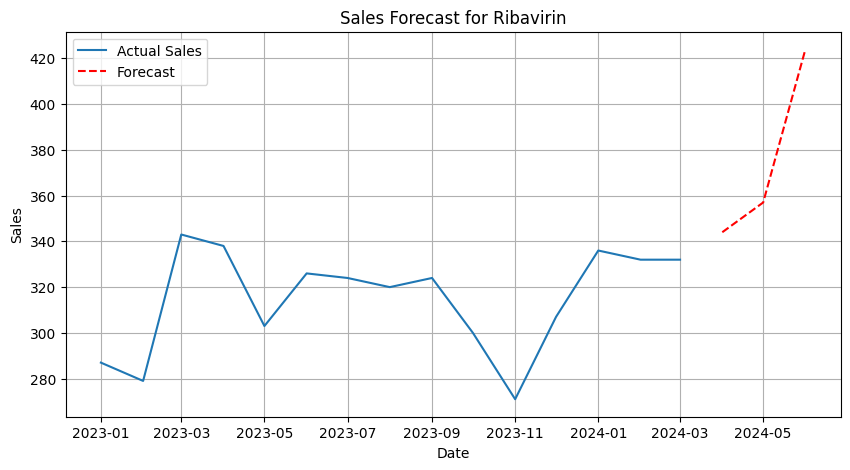

In [ ]:
import pandas as pd
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import joblib

# Load your data
df = pd.read_csv('/content/Nipha.csv')

# Convert 'Date' to datetime format explicitly specifying the format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

# Sort data by Drug and Date
df.sort_values(by=['Drug', 'Date'], inplace=True)

# Fill missing values if necessary
df.ffill(inplace=True)

def forecast_demand(df, drug_name, periods=3, growth_rate=0.1):
    drug_data = df[df['Drug'] == drug_name]
    drug_data.set_index('Date', inplace=True)
    drug_data = drug_data['Sales']

    # Ensure the index frequency is set
    drug_data.index = pd.DatetimeIndex(drug_data.index).to_period('M')

    # Fit ARIMA model
    if len(drug_data) < 6:  # Check for minimum number of data points
        raise ValueError(f"Not enough data points for {drug_name}. At least 6 data points are required.")

    model = ARIMA(drug_data, order=(5, 1, 0))  # Adjust order as needed
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=periods)

    # Apply exponential growth factor
    for i in range(1, periods + 1):
        forecast.iloc[i-1] *= (1 + growth_rate) ** i

    # Round forecast to the nearest integer
    forecast = forecast.round().astype(int)

    return drug_data, forecast, model_fit

# Forecast for Ribavirin
drug_name = 'Ribavirin'  # Replace with the actual drug name
actual_sales, forecast, model_fit = forecast_demand(df, drug_name)

# Save actual sales and forecast to HDF5
forecast_data = pd.DataFrame({'Actual_Sales': actual_sales, 'Forecast': forecast}, index=actual_sales.index.append(pd.date_range(start=actual_sales.index[-1].to_timestamp(), periods=len(forecast) + 1, freq='M')[1:]))
forecast_data.to_hdf('forecast_data.h5', key='forecast', mode='w')

# Save model parameters
model_params = pd.DataFrame({'params': model_fit.params})
model_params.to_hdf('forecast_data.h5', key='model_params', mode='a')

# Save the ARIMA model
joblib.dump(model_fit, 'arima_model.pkl')

# Plot the actual sales and the forecast
plt.figure(figsize=(10, 5))
plt.plot(actual_sales.index.to_timestamp(), actual_sales, label='Actual Sales')
plt.plot(forecast.index.to_timestamp(), forecast, label='Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Sales Forecast for {drug_name}')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib

# Save the ARIMA model
with open('arima_model.pkl', 'wb') as model_file:
    joblib.dump(model_fit, model_file)

In [ ]:
# import pickle

# # Save the ARIMA model
# with open('arima_model.pkl', 'wb') as model_file:
#     pickle.dump(model_fit, model_file)